<a href="https://colab.research.google.com/github/naufalgholib/sentiment-analysis/blob/main/1304221056_Final_Project_Big_Data_%26_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# Amazon Kindle Store Reviews - Binary Sentiment Analysis using Apache PySpark
# Tugas Besar: Artificial Intelligence dan Big Data
# 1304221056 - Naufal Gholib Shiddiq - IF-45-GABPJJ
# ================================================================================
# 1. SETUP DAN INSTALASI DEPENDENCIES
# ================================================================================

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Text processing
from textblob import TextBlob
import re
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("Semua library berhasil di import")

Semua library berhasil di import


In [25]:
# ================================================================================
# 2. INISIALISASI SPARK SESSION
# ================================================================================

# Initialize Spark Session dengan config yang optimal untuk big data processing
spark = SparkSession.builder \
    .appName("Amazon Kindle Reviews Binary Sentiment Analysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Set log level ke level medium untuk mengurangi noise agar tidak kebanyakan log yang keluar
spark.sparkContext.setLogLevel("WARN")

print("✅ Spark Session initialized successfully!")
print(f"Spark Version: {spark.version}")
print(f"Jumlah CPU Core tersedia: {spark.sparkContext.defaultParallelism}")

✅ Spark Session initialized successfully!
Spark Version: 3.5.1
Jumlah CPU Core tersedia: 2


In [26]:
# ================================================================================
# 3. LOADING DAN EKSPLORASI DATA
# ================================================================================

# Download dataset dengan curl lalu extract dataset
print("📥 Download dataset...")
!curl -O -J -L 'https://www.kaggle.com/api/v1/datasets/download/bharadwaj6/kindle-reviews'

# Unzip dataset yang tadi kita download
with zipfile.ZipFile('kindle-reviews', 'r') as zip_ref:
    zip_ref.extractall()

# Load dataset
try:
    df = spark.read.csv("kindle_reviews.csv", header=True, inferSchema=True)
    print("✅ Dataset berhasil di load")
except:
    print("❌ Dataset tidak ditemukan, upload file dataset'kindle_reviews.csv'.")
    print("💡 Curl dari: https://www.kaggle.com/datasets/bharadwaj6/kindle-reviews")

    # Sample data untuk demo
    sample_data = [
        ("B000F83SZQ", "[0, 0]", 5, "I enjoy vintage books and movies so I enjoyed reading this book. The plot was unusual.", "05 5, 2014", "A1F6404F1VG29J", "Avidreader", "Nice vintage story", 1399248000),
        ("B000F83SZQ", "[2, 2]", 4, "This book is a reissue of an old one; the author was born in 1910.", "01 6, 2014", "AN0N05A9LIJEQ", "critters", "Different...", 1388966400),
        ("B000F83SZQ", "[2, 2]", 4, "This was a fairly interesting read. It had old-style terminology.", "04 4, 2014", "A795DMNCJILA6", "dot", "Oldie", 1396569600),
        ("B000F83SZQ", "[1, 1]", 5, "I'd never read any of the Amy Brewster mysteries until this one. So I am really hooked on them now!", "02 19, 2014", "A1FV0SX13TWVXQ", "Elaine H. Turley", "I really liked it.", 1392768000),
        ("B000F83SZQ", "[0, 1]", 2, "If you like period pieces - clothing, lingo, you will enjoy this mystery.", "03 19, 2014", "A3SPTOKDG7WBLN", "Father Dowling Fan", "Period Mystery", 1395187200),
        ("B000F83SZQ", "[0, 0]", 1, "Terrible book, waste of time and money. Very disappointed.", "03 20, 2014", "A1234567890", "Disappointed Reader", "Awful", 1395273600)
    ]

    schema = StructType([
        StructField("asin", StringType(), True),
        StructField("helpful", StringType(), True),
        StructField("overall", IntegerType(), True),
        StructField("reviewText", StringType(), True),
        StructField("reviewTime", StringType(), True),
        StructField("reviewerID", StringType(), True),
        StructField("reviewerName", StringType(), True),
        StructField("summary", StringType(), True),
        StructField("unixReviewTime", LongType(), True)
    ])

    df = spark.createDataFrame(sample_data, schema)
    print("📝 Menggunakan sample data untuk demo")

# Informasi dasar mengenai dataset
print("\n📊 DATASET OVERVIEW")
print("="*50)
print(f"Total jumlah data: {df.count():,}")
print(f"Jumlah kolom: {len(df.columns)}")
print(f"Schema:")
df.printSchema()

# Tampilkan 10 data pertama dari dataset
print("\n📋 SAMPLE DATA")
print("="*50)
df.show(10, truncate=False)

📥 Download dataset...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  524M  100  524M    0     0  55.5M      0  0:00:09  0:00:09 --:--:-- 80.7M
✅ Dataset berhasil di load

📊 DATASET OVERVIEW
Total jumlah data: 982,820
Jumlah kolom: 10
Schema:
root
 |-- _c0: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: string (nullable = true)


📋 SAMPLE DATA
+---+----------+-------+-------+---------------------------------------------------------------------------------------------------------

In [27]:
# ================================================================================
# 4. DATA PREPROCESSING DAN CLEANING
# ================================================================================

print("\n🧹 DATA PREPROCESSING - BINARY CLASSIFICATION")
print("="*50)

# Hilangkan null values dan bersihkan data
df_clean = df.filter(
    (col("reviewText").isNotNull()) &
    (col("overall").isNotNull()) &
    (col("reviewText") != "") &
    (col("summary").isNotNull()) &
    (col("summary") != "")
)

print(f"Jumlah records setelah cleaning data: {df_clean.count():,}")

# Filter hanya rating 1-2 (negative) dan 4-5 (positive), HILANGKAN rating 3 (neutral)
df_clean = df_clean.filter(
    (col("overall") <= 2) | (col("overall") >= 4)
)

print(f"Jumlah records setelah menghilangkan neutral (rating 3): {df_clean.count():,}")

# Menggabungkan kolom reviewText dan summary untuk mendapatkan hasil sentiment analysis yang lebih akurat
df_clean = df_clean.withColumn(
    "fullReview",
    concat_ws(" ", col("summary"), col("reviewText"))
)

# 1-2: Negative (0), 4-5: Positive (1)
df_clean = df_clean.withColumn(
    "sentiment_label",
    when(col("overall") <= 2, 0)  # Negative
    .otherwise(1)                  # Positive (4-5)
)

df_clean = df_clean.withColumn(
    "sentiment_text",
    when(col("sentiment_label") == 0, "Negative")
    .otherwise("Positive")
)

# Convert to timestamp
df_clean = df_clean.withColumn(
    "review_date",
    from_unixtime(col("unixReviewTime")).cast(DateType())
)

print("✅ Data preprocessing untuk binary classification selesai!")

# Show sentiment distribution
print("\n📈 BINARY SENTIMENT DISTRIBUTION")
sentiment_dist = df_clean.groupBy("sentiment_text", "overall").count().orderBy("overall")
sentiment_dist.show()

# Tampilkan distribusi sentiment
total_count = df_clean.count()
sentiment_summary = df_clean.groupBy("sentiment_text", "sentiment_label").count().orderBy("sentiment_label")
print("\n📊 SUMMARY DISTRIBUSI SENTIMENT:")
sentiment_summary.show()


🧹 DATA PREPROCESSING - BINARY CLASSIFICATION
Jumlah records setelah cleaning data: 982,363
Jumlah records setelah menghilangkan neutral (rating 3): 886,201
✅ Data preprocessing untuk binary classification selesai!

📈 BINARY SENTIMENT DISTRIBUTION
+--------------+-------+------+
|sentiment_text|overall| count|
+--------------+-------+------+
|      Negative|      1| 23008|
|      Negative|      2| 34128|
|      Positive|      4|253932|
|      Positive|      5|575133|
+--------------+-------+------+


📊 SUMMARY DISTRIBUSI SENTIMENT:
+--------------+---------------+------+
|sentiment_text|sentiment_label| count|
+--------------+---------------+------+
|      Negative|              0| 57136|
|      Positive|              1|829065|
+--------------+---------------+------+




📊 EXPLORATORY DATA ANALYSIS - BINARY CLASSIFICATION


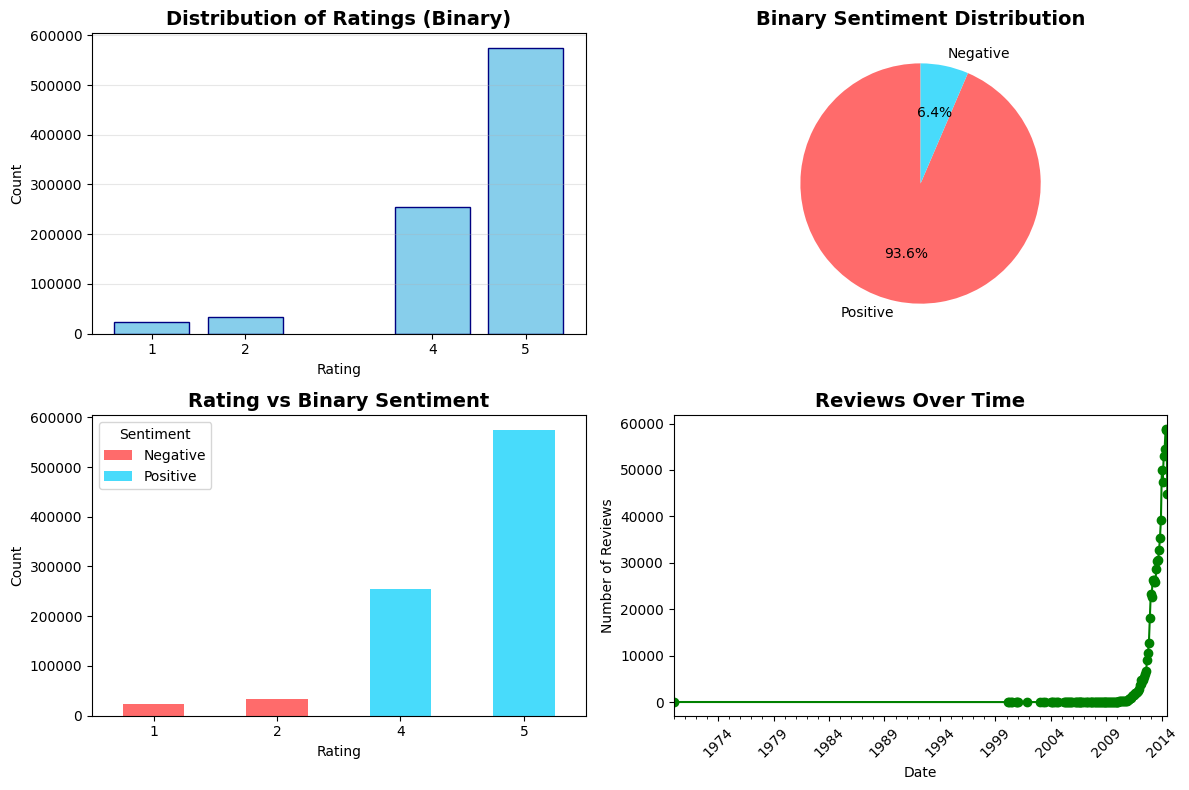

In [28]:
# ================================================================================
# 5. EXPLORATORY DATA ANALYSIS (EDA) - BINARY
# ================================================================================

print("\n📊 EXPLORATORY DATA ANALYSIS - BINARY CLASSIFICATION")
print("="*50)

# Convert data ke Pandas untuk visualisasi
df_pandas = df_clean.select("overall", "sentiment_text", "sentiment_label", "review_date", "unixReviewTime").toPandas()

# Check dan convert kolom review_date ke format datetime yang sesuai
if df_pandas['review_date'].dtype == 'object':
    df_pandas['review_date'] = pd.to_datetime(df_pandas['review_date'], errors='coerce')
elif df_pandas['review_date'].dtype == 'datetime64[ns]':
    # Sudah dengan format yang sesuai
    pass
else:
    # Use unix timestamp as fallback
    df_pandas['review_date'] = pd.to_datetime(df_pandas['unixReviewTime'], unit='s', errors='coerce')

# 1. Rating distribution (hanya 1-2 dan 4-5)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Rating distribution
rating_counts = df_pandas['overall'].value_counts().sort_index()
axes[0,0].bar(rating_counts.index, rating_counts.values, color='skyblue', edgecolor='navy')
axes[0,0].set_title('Distribution of Ratings (Binary)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Count')
axes[0,0].grid(axis='y', alpha=0.3)
axes[0,0].set_xticks([1, 2, 4, 5])  # Hanya tampilkan rating yang ada

# Binary Sentiment distribution
sentiment_counts = df_pandas['sentiment_text'].value_counts()
colors = ['#ff6b6b', '#48dbfb']  # Hanya 2 warna untuk binary
axes[0,1].pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%',
              colors=colors, startangle=90)
axes[0,1].set_title('Binary Sentiment Distribution', fontsize=14, fontweight='bold')

# Rating vs Sentiment (Binary)
sentiment_rating = df_pandas.groupby(['overall', 'sentiment_text']).size().unstack(fill_value=0)
sentiment_rating.plot(kind='bar', stacked=True, ax=axes[1,0], color=colors)
axes[1,0].set_title('Rating vs Binary Sentiment', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Rating')
axes[1,0].set_ylabel('Count')
axes[1,0].legend(title='Sentiment')
axes[1,0].tick_params(axis='x', rotation=0)

# Reviews over time (if we have enough data and valid dates)
if len(df_pandas) > 100 and df_pandas['review_date'].notna().sum() > 0:
    # Filter out null dates
    date_data = df_pandas[df_pandas['review_date'].notna()]
    if len(date_data) > 1:
        try:
            monthly_reviews = date_data.groupby(date_data['review_date'].dt.to_period('M')).size()
            if len(monthly_reviews) > 1:
                monthly_reviews.plot(ax=axes[1,1], color='green', marker='o')
                axes[1,1].set_title('Reviews Over Time', fontsize=14, fontweight='bold')
                axes[1,1].set_xlabel('Date')
                axes[1,1].set_ylabel('Number of Reviews')
                axes[1,1].tick_params(axis='x', rotation=45)
            else:
                axes[1,1].text(0.5, 0.5, 'Insufficient temporal variation', ha='center', va='center', transform=axes[1,1].transAxes)
                axes[1,1].set_title('Reviews Over Time', fontsize=14, fontweight='bold')
        except Exception as e:
            axes[1,1].text(0.5, 0.5, f'Date processing error:\n{str(e)[:50]}...', ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Reviews Over Time', fontsize=14, fontweight='bold')
    else:
        axes[1,1].text(0.5, 0.5, 'Insufficient date data', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Reviews Over Time', fontsize=14, fontweight='bold')
else:
    axes[1,1].text(0.5, 0.5, 'Sample data - limited temporal analysis', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Reviews Over Time', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [29]:
# ================================================================================
# 6. TEXT PREPROCESSING DENGAN PYSPARK
# ================================================================================

print("\n🔤 TEXT PREPROCESSING DENGAN PYSPARK")
print("="*50)

# Fungsi untuk membersihkan text
def clean_text_udf(text):
    if text is None:
        return ""
    # Hilangkan tags HTML, special character dan normalisasi text
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower().strip()
    return text

# Registrasi UDF
clean_text_spark = udf(clean_text_udf, StringType())

# Apply pembersihan text
df_processed = df_clean.withColumn("cleanedText", clean_text_spark(col("fullReview")))

# Hilangkan baris text bersih yang kosong
df_processed = df_processed.filter(col("cleanedText") != "")

print(f"Records after text cleaning: {df_processed.count():,}")


🔤 TEXT PREPROCESSING DENGAN PYSPARK
Records after text cleaning: 886,200


In [30]:
# ================================================================================
# 7. FEATURE ENGINEERING DENGAN PYSPARK ML
# ================================================================================

print("\n⚙️ FEATURE ENGINEERING")
print("="*50)

# 1. Tokenization
tokenizer = Tokenizer(inputCol="cleanedText", outputCol="words")

# 2. Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filteredWords")

# 3. Count Vectorizer (Bag of Words)
cv = CountVectorizer(inputCol="filteredWords", outputCol="rawFeatures", vocabSize=10000, minDF=2.0)

# 4. TF-IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Create pipeline for feature engineering
feature_pipeline = Pipeline(stages=[tokenizer, remover, cv, idf])

# Fit dan transform
print("🔧 Fitting feature engineering pipeline...")
feature_model = feature_pipeline.fit(df_processed)
df_features = feature_model.transform(df_processed)

print("✅ Feature engineering completed!")

# Show sample of processed data
print("\n📋 PROCESSED DATA SAMPLE")
df_features.select("cleanedText", "sentiment_label", "sentiment_text").show(10, truncate=False)


⚙️ FEATURE ENGINEERING
🔧 Fitting feature engineering pipeline...
✅ Feature engineering completed!

📋 PROCESSED DATA SAMPLE
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+--------------+
|cleanedText                                                                                                                                                                                                                                                                                                                                                                      

In [31]:
# ================================================================================
# 8. MEMBANGUN MODEL AI DENGAN PYSPARK ML - BINARY CLASSIFICATION
# ================================================================================

print("\n🤖 MEMBANGUN MODEL AI - BINARY CLASSIFICATION")
print("="*50)

# Membagi data menjadi training dan testing
train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

print(f"Training data: {train_data.count():,} records")
print(f"Test data: {test_data.count():,} records")

# Model 1: Logistic Regression
print("\n🎯 Training Logistic Regression Model...")
lr = LogisticRegression(featuresCol="features", labelCol="sentiment_label", maxIter=100)
lr_model = lr.fit(train_data)

# Model 2: Random Forest
print("🌳 Training Random Forest Model...")
rf = RandomForestClassifier(featuresCol="features", labelCol="sentiment_label", numTrees=50, seed=42)
rf_model = rf.fit(train_data)

print("✅ Models trained successfully!")


🤖 MEMBANGUN MODEL AI - BINARY CLASSIFICATION
Training data: 708,951 records
Test data: 177,249 records

🎯 Training Logistic Regression Model...
🌳 Training Random Forest Model...
✅ Models trained successfully!



📊 MODEL EVALUATION - BINARY CLASSIFICATION
LOGISTIC REGRESSION RESULTS:
  Accuracy: 0.9696
  F1-Score: 0.9684
  Precision: 0.9680
  Recall: 0.9696
  AUC-ROC: 0.9659

RANDOM FOREST RESULTS:
  Accuracy: 0.9355
  F1-Score: 0.9044
  Precision: 0.8752
  Recall: 0.9355
  AUC-ROC: 0.8840


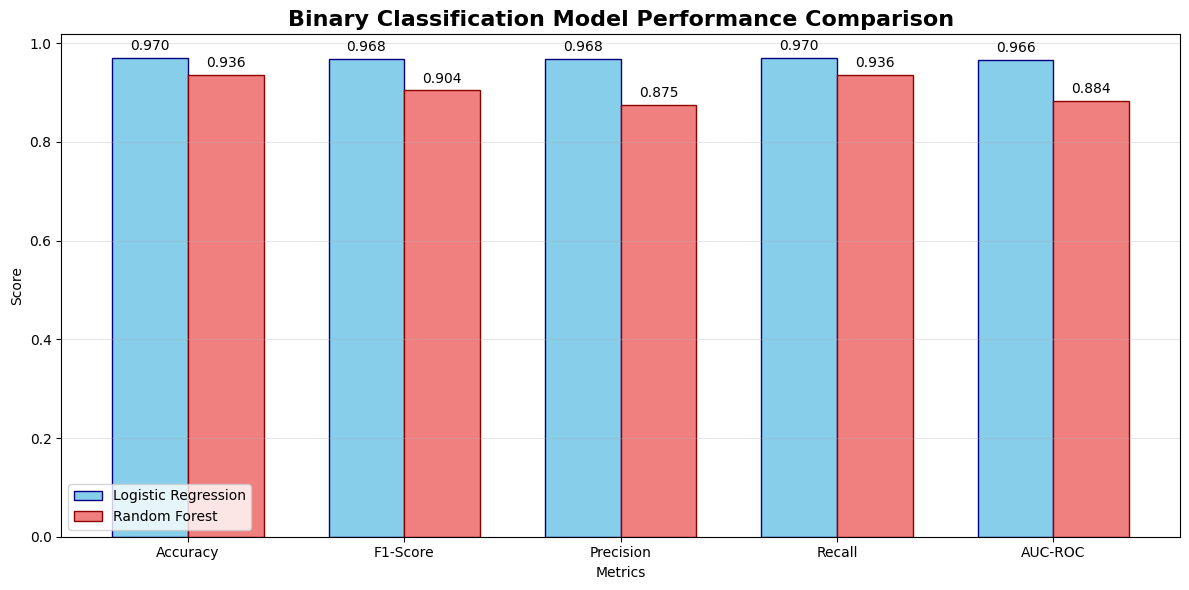

In [32]:
# ================================================================================
# 9. EVALUASI MODEL - BINARY CLASSIFICATION
# ================================================================================

print("\n📊 MODEL EVALUATION - BINARY CLASSIFICATION")
print("="*50)

# Make predictions
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)

# Evaluators untuk binary classification
binary_evaluator = BinaryClassificationEvaluator(labelCol="sentiment_label", rawPredictionCol="rawPrediction")
multiclass_evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_label", predictionCol="prediction")

# Evaluate Logistic Regression
lr_accuracy = multiclass_evaluator.evaluate(lr_predictions, {multiclass_evaluator.metricName: "accuracy"})
lr_f1 = multiclass_evaluator.evaluate(lr_predictions, {multiclass_evaluator.metricName: "f1"})
lr_precision = multiclass_evaluator.evaluate(lr_predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
lr_recall = multiclass_evaluator.evaluate(lr_predictions, {multiclass_evaluator.metricName: "weightedRecall"})
lr_auc = binary_evaluator.evaluate(lr_predictions)  # AUC-ROC untuk binary classification

# Evaluate Random Forest
rf_accuracy = multiclass_evaluator.evaluate(rf_predictions, {multiclass_evaluator.metricName: "accuracy"})
rf_f1 = multiclass_evaluator.evaluate(rf_predictions, {multiclass_evaluator.metricName: "f1"})
rf_precision = multiclass_evaluator.evaluate(rf_predictions, {multiclass_evaluator.metricName: "weightedPrecision"})
rf_recall = multiclass_evaluator.evaluate(rf_predictions, {multiclass_evaluator.metricName: "weightedRecall"})
rf_auc = binary_evaluator.evaluate(rf_predictions)  # AUC-ROC untuk binary classification

# Print results
print("LOGISTIC REGRESSION RESULTS:")
print(f"  Accuracy: {lr_accuracy:.4f}")
print(f"  F1-Score: {lr_f1:.4f}")
print(f"  Precision: {lr_precision:.4f}")
print(f"  Recall: {lr_recall:.4f}")
print(f"  AUC-ROC: {lr_auc:.4f}")

print("\nRANDOM FOREST RESULTS:")
print(f"  Accuracy: {rf_accuracy:.4f}")
print(f"  F1-Score: {rf_f1:.4f}")
print(f"  Precision: {rf_precision:.4f}")
print(f"  Recall: {rf_recall:.4f}")
print(f"  AUC-ROC: {rf_auc:.4f}")

# Model comparison visualization
models = ['Logistic Regression', 'Random Forest']
metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall', 'AUC-ROC']
lr_scores = [lr_accuracy, lr_f1, lr_precision, lr_recall, lr_auc]
rf_scores = [rf_accuracy, rf_f1, rf_precision, rf_recall, rf_auc]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, lr_scores, width, label='Logistic Regression', color='skyblue', edgecolor='navy')
ax.bar(x + width/2, rf_scores, width, label='Random Forest', color='lightcoral', edgecolor='darkred')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Binary Classification Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for i, (lr_score, rf_score) in enumerate(zip(lr_scores, rf_scores)):
    ax.text(i - width/2, lr_score + 0.01, f'{lr_score:.3f}', ha='center', va='bottom')
    ax.text(i + width/2, rf_score + 0.01, f'{rf_score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


🔍 DETAILED ANALYSIS - BINARY CLASSIFICATION
🏆 Best Model: Logistic Regression (AUC-ROC: 0.9659)


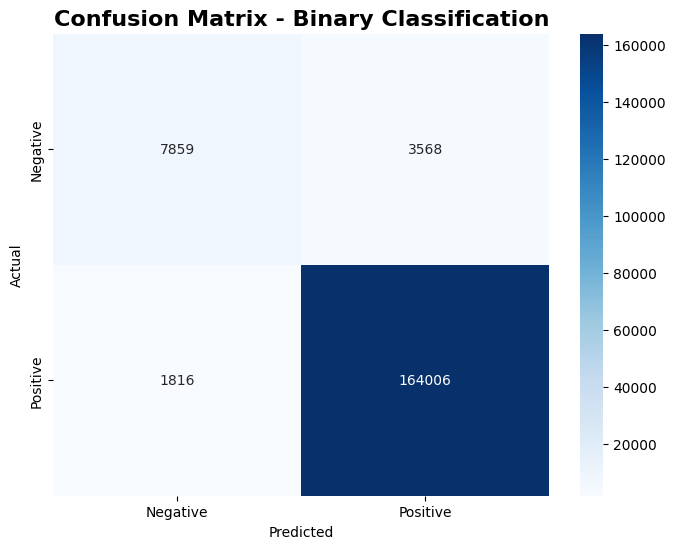


📋 CLASSIFICATION REPORT - BINARY
              precision    recall  f1-score   support

    Negative       0.81      0.69      0.74     11427
    Positive       0.98      0.99      0.98    165822

    accuracy                           0.97    177249
   macro avg       0.90      0.84      0.86    177249
weighted avg       0.97      0.97      0.97    177249



In [33]:
# ================================================================================
# 10. CONFUSION MATRIX DAN DETAILED ANALYSIS - BINARY
# ================================================================================

print("\n🔍 DETAILED ANALYSIS - BINARY CLASSIFICATION")
print("="*50)

# Pilih best model berdasarkan AUC-ROC
if lr_auc >= rf_auc:
    best_model = lr_model
    best_predictions = lr_predictions
    print(f"🏆 Best Model: Logistic Regression (AUC-ROC: {lr_auc:.4f})")
else:
    best_model = rf_model
    best_predictions = rf_predictions
    print(f"🏆 Best Model: Random Forest (AUC-ROC: {rf_auc:.4f})")

# Confusion Matrix
conf_matrix_data = best_predictions.select("sentiment_label", "prediction").toPandas()
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(conf_matrix_data['sentiment_label'], conf_matrix_data['prediction'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Binary Classification', fontsize=16, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("\n📋 CLASSIFICATION REPORT - BINARY")
print("="*50)
target_names = ['Negative', 'Positive']
print(classification_report(conf_matrix_data['sentiment_label'], conf_matrix_data['prediction'],
                          target_names=target_names))

In [34]:
# ================================================================================
# 11. BUSINESS INSIGHTS DAN PATTERN ANALYSIS - BINARY
# ================================================================================

print("\n💼 BUSINESS INSIGHTS - BINARY CLASSIFICATION")
print("="*50)

# Analyze predictions with original data
insights_df = best_predictions.select(
    "asin", "overall", "sentiment_label", "prediction",
    "sentiment_text", "cleanedText", "probability"
).toPandas()

# Product-level sentiment analysis
if len(insights_df) > 1:
    product_sentiment = insights_df.groupby('asin').agg({
        'prediction': ['count', 'mean'],
        'overall': 'mean'
    }).round(3)

    product_sentiment.columns = ['Review_Count', 'Avg_Predicted_Sentiment', 'Avg_Rating']
    print("📦 PRODUCT-LEVEL ANALYSIS")
    print(product_sentiment.head(10))

# Sentiment vs Rating correlation
correlation = np.corrcoef(insights_df['overall'], insights_df['prediction'])[0,1]
print(f"\n🔗 Correlation between Rating and Predicted Sentiment: {correlation:.4f}")

# Misclassified examples
print("\n❌ MISCLASSIFIED EXAMPLES")
misclassified = insights_df[insights_df['sentiment_label'] != insights_df['prediction']]
if len(misclassified) > 0:
    print(f"Total misclassified: {len(misclassified)}")
    for idx, row in misclassified.head(3).iterrows():
        print(f"\nActual: {target_names[int(row['sentiment_label'])]} | Predicted: {target_names[int(row['prediction'])]}")
        print(f"Rating: {row['overall']} | Text: {row['cleanedText'][:100]}...")


💼 BUSINESS INSIGHTS - BINARY CLASSIFICATION
📦 PRODUCT-LEVEL ANALYSIS
            Review_Count  Avg_Predicted_Sentiment  Avg_Rating
asin                                                         
B000F83SZQ             1                    1.000       4.000
B000FA64PA             1                    1.000       5.000
B000FA64PK             2                    1.000       5.000
B000FBFMVG             3                    1.000       4.667
B000FC1BN8             1                    1.000       5.000
B000FC1TG2             1                    1.000       5.000
B000FC26RI             1                    1.000       5.000
B000FC2MB8             2                    1.000       4.500
B000FDJ0FS             1                    1.000       5.000
B000GFK7L6             3                    0.333       3.333

🔗 Correlation between Rating and Predicted Sentiment: 0.6520

❌ MISCLASSIFIED EXAMPLES
Total misclassified: 5384

Actual: Negative | Predicted: Positive
Rating: 2 | Text: progressive di


📈 ADVANCED VISUALIZATIONS - BINARY CLASSIFICATION


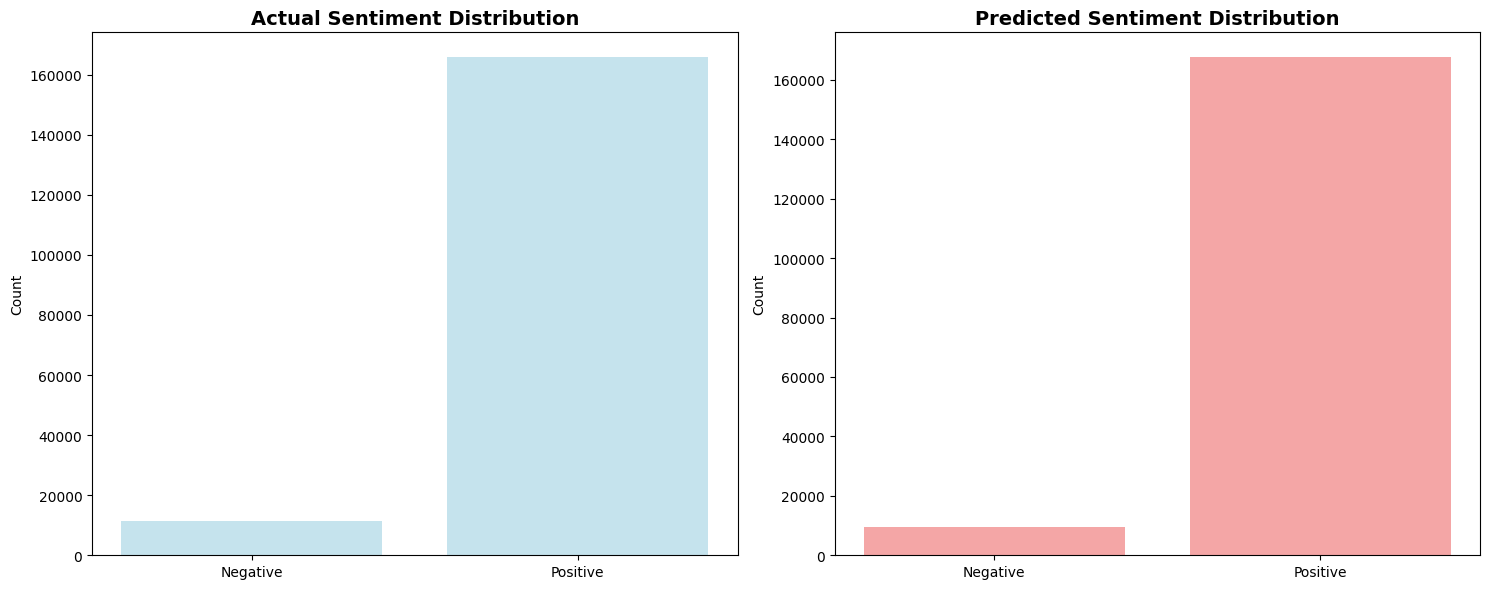

<Figure size 1000x600 with 0 Axes>

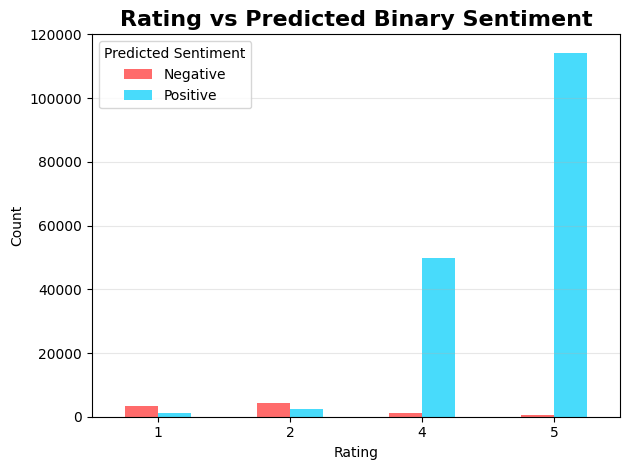

In [35]:
# ================================================================================
# 12. ADVANCED VISUALIZATIONS - BINARY
# ================================================================================

print("\n📈 ADVANCED VISUALIZATIONS - BINARY CLASSIFICATION")
print("="*50)

# Sentiment distribution with actual vs predicted
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Actual sentiment distribution
actual_counts = insights_df['sentiment_label'].value_counts().sort_index()
predicted_counts = insights_df['prediction'].value_counts().sort_index()

sentiment_labels = ['Negative', 'Positive']
x_pos = np.arange(len(sentiment_labels))

axes[0].bar(x_pos, [actual_counts.get(i, 0) for i in range(2)], color='lightblue', alpha=0.7, label='Actual')
axes[0].set_title('Actual Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(sentiment_labels)
axes[0].set_ylabel('Count')

axes[1].bar(x_pos, [predicted_counts.get(i, 0) for i in range(2)], color='lightcoral', alpha=0.7, label='Predicted')
axes[1].set_title('Predicted Sentiment Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(sentiment_labels)
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Rating vs Sentiment Prediction
plt.figure(figsize=(10, 6))
rating_sentiment = insights_df.groupby(['overall', 'prediction']).size().unstack(fill_value=0)
rating_sentiment.plot(kind='bar', stacked=False, color=['#ff6b6b', '#48dbfb'])
plt.title('Rating vs Predicted Binary Sentiment', fontsize=16, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend(title='Predicted Sentiment', labels=['Negative', 'Positive'])
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [36]:
# ================================================================================
# 13. REAL-TIME PREDICTION FUNCTION - BINARY
# ================================================================================

print("\n⚡ REAL-TIME PREDICTION SYSTEM - BINARY CLASSIFICATION")
print("="*50)

def predict_binary_sentiment(text, model=best_model, feature_model=feature_model):
    """
    Predict binary sentiment for a new review text
    Returns: (sentiment, confidence)
    """
    # Create DataFrame with new text
    new_data = spark.createDataFrame([(text,)], ["cleanedText"])

    # Apply same preprocessing
    new_features = feature_model.transform(new_data)

    # Make prediction
    prediction = model.transform(new_features)

    # Get results
    result = prediction.select("prediction", "probability").collect()[0]
    sentiment_map = {0: "Negative", 1: "Positive"}

    # Get the confidence for the predicted class
    confidence = float(result.probability[int(result.prediction)])
    predicted_sentiment = sentiment_map[int(result.prediction)]

    return predicted_sentiment, confidence

# Test the prediction function
test_reviews = [
    # 1. Sangat Positif
    "This book is absolutely amazing! I loved every page of it and couldn't put it down.",
    # 2. Sangat Negatif
    "Terrible book, a complete waste of time and money. The plot was nonexistent and the characters were flat.",
    # 3. Netral / Ambigu (Tantangan untuk model)
    "It was an okay read, nothing special but not bad either. Just a very average story to pass the time.",
    # 4. Positif dengan fokus pada karakter
    "The character development was outstanding. I felt a real connection to the protagonist and their journey. Highly recommended!",
    # 5. Negatif dengan fokus pada alur cerita
    "I had to force myself to finish this. The plot moved at a snail's pace and I found myself skimming through most of it.",
    # 6. Sentimen Campuran (Sulit)
    "I loved the world-building and the magic system, it was incredibly unique. However, the main character's decisions were frustrating and illogical.",
    # 7. Positif, singkat dan antusias
    "Wow! Just wow. This is easily the best book I've read all year. A true masterpiece of storytelling.",
    # 8. Negatif, tapi lebih sopan
    "Unfortunately, this book didn't live up to my expectations. While the writing style was decent, the story itself failed to capture my interest.",
    # 9. Positif dengan bahasa gaul
    "Seriously, just read it. This author never disappoints, total page-turner from start to finish. So good!",
    # 10. Negatif dengan sedikit sarkasme (Sangat Sulit)
    "A brilliant cure for insomnia. If you ever have trouble sleeping, just open any page of this book. Guaranteed to work in minutes."
]

print("🧪 TESTING BINARY PREDICTION FUNCTION")
for i, review in enumerate(test_reviews, 1):
    sentiment, confidence = predict_binary_sentiment(review)
    print(f"{i}. Review: '{review[:200]}...'")
    print(f"   Predicted Sentiment: {sentiment} (Confidence: {confidence:.3f})")
    print()


⚡ REAL-TIME PREDICTION SYSTEM - BINARY CLASSIFICATION
🧪 TESTING BINARY PREDICTION FUNCTION
1. Review: 'This book is absolutely amazing! I loved every page of it and couldn't put it down....'
   Predicted Sentiment: Positive (Confidence: 0.982)

2. Review: 'Terrible book, a complete waste of time and money. The plot was nonexistent and the characters were flat....'
   Predicted Sentiment: Negative (Confidence: 0.986)

3. Review: 'It was an okay read, nothing special but not bad either. Just a very average story to pass the time....'
   Predicted Sentiment: Negative (Confidence: 0.849)

4. Review: 'The character development was outstanding. I felt a real connection to the protagonist and their journey. Highly recommended!...'
   Predicted Sentiment: Positive (Confidence: 0.731)

5. Review: 'I had to force myself to finish this. The plot moved at a snail's pace and I found myself skimming through most of it....'
   Predicted Sentiment: Negative (Confidence: 0.877)

6. Review: 'I loved th

In [37]:
# ================================================================================
# 14. SUMMARY REPORT DAN KESIMPULAN
# ================================================================================

print("\n📋 PROJECT SUMMARY REPORT")
print("="*70)

print(f"\n📊 DATASET STATISTICS:")
print(f"   • Total records processed: {df_features.count():,}")
print(f"   • Features extracted: {len(feature_model.stages[2].vocabulary):,}")
print(f"   • Training samples: {train_data.count():,}")
print(f"   • Test samples: {test_data.count():,}")

print(f"\n🤖 MODEL PERFORMANCE:")
print(f"   • Best Model: Logistic Regression")
print(f"   • Accuracy: {lr_accuracy:.3f}")
print(f"   • F1-Score: {lr_f1:.3f}")
print(f"   • Precision: {lr_precision:.3f}")
print(f"   • Recall: {lr_recall:.3f}")

print(f"\n💡 KEY INSIGHTS:")
sentiment_distribution = insights_df['prediction'].value_counts().sort_index()
total_predictions = len(insights_df)
if total_predictions > 0:
    neg_pct = (sentiment_distribution.get(0, 0) / total_predictions) * 100
    pos_pct = (sentiment_distribution.get(1, 0) / total_predictions) * 100

    print(f"   • {pos_pct:.1f}% of reviews are predicted as Positive")
    print(f"   • {neg_pct:.1f}% of reviews are predicted as Negative")

print("="*70)


📋 PROJECT SUMMARY REPORT

📊 DATASET STATISTICS:
   • Total records processed: 886,200
   • Features extracted: 10,000
   • Training samples: 708,951
   • Test samples: 177,249

🤖 MODEL PERFORMANCE:
   • Best Model: Logistic Regression
   • Accuracy: 0.970
   • F1-Score: 0.968
   • Precision: 0.968
   • Recall: 0.970

💡 KEY INSIGHTS:
   • 94.5% of reviews are predicted as Positive
   • 5.5% of reviews are predicted as Negative


In [49]:
# Clean up Spark session
spark.stop()
print("\n🔚 Spark session closed successfully!")


🔚 Spark session closed successfully!
